In [8]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import time
import re #정규식

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC #△3 :지연시간 대기를 위한 라이브러리

import matplotlib.pyplot as plt #그래프 라이브러리

from bs4 import BeautifulSoup
import requests



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-9-a4b0b5eb4958>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-9-a4b0b5eb4958>:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
<ipython-input-9-a4b0b5eb4958>:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
<ipython-input-9-a4b0b5eb4958>:17: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  every_time_content = driver.find

시간별 기온
[('06', '-9'), ('07', '-9'), ('08', '-8'), ('09', '-7'), ('10', '-5'), ('11', '-4'), ('12', '-3'), ('13', '-3'), ('14', '-2'), ('15', '-2'), ('16', '-2'), ('17', '-3'), ('18', '-3'), ('19', '-4'), ('20', '-5'), ('21', '-5'), ('22', '-6'), ('23', '-7'), ('00', '-8'), ('01', '-8'), ('02', '-9'), ('03', '-9'), ('04', '-9'), ('05', '-10')]
시간별 강수확률
[('06', '7'), ('07', '9'), ('08', '10'), ('09', '9'), ('10', '7'), ('11', '4'), ('12', '1'), ('13', '1'), ('14', '4'), ('15', '7'), ('16', '8'), ('17', '8'), ('18', '9'), ('19', '9'), ('20', '10'), ('21', '11'), ('22', '15'), ('23', '21'), ('00', '26'), ('01', '26'), ('02', '23'), ('03', '20'), ('04', '18'), ('05', '15')]


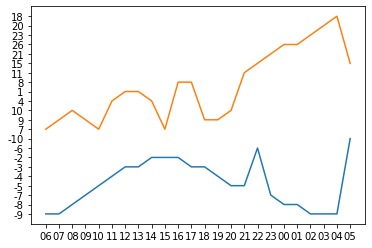

In [9]:
#BBC Weather 크롤링 주소 / 한국의 25개 지역을 영문으로 지원해줌.
#BBC Weather/ 시작페이지
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://www.bbc.com/weather")

#검색창에 도시명 검색
elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
elem.clear()
elem.send_keys("Seoul")
elem.send_keys(Keys.RETURN)
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "wr-time-slot-primary__hours")))
#도시명 입력하고 난 후
driver.execute_script("window.scrollTo(0, 200)")
elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
elem.click() #클릭

every_time_content = driver.find_elements_by_class_name("wr-time-slot-primary__hours") #매 시간을 리스트로 받아온다.
bbc_time = list()
for i in every_time_content:
    time = i.text
    bbc_time.append(time)
every_temp = driver.find_elements_by_css_selector(".wr-temperature--time-slot > .wr-value--temperature--c")
bbc_temp = list() #모든 온도를 받을 리스트
for i in every_temp:
    temp = i.text.replace("°", "")
    bbc_temp.append(temp)
every_PP = driver.find_elements_by_css_selector(".wr-time-slot-primary__precipitation > .wr-u-font-weight-500")
bbc_precip = list() #모든 강수확률을 받을 리스트
for i in every_PP:
    precip = i.text.replace("%", "")
    precip = precip.replace("chance of precipitation", "")
    precip = precip.replace('\n', '')
    bbc_precip.append(precip)
    
bbc_temp_per_time = list() #(시간, 기온)형태의 리스트
bbc_precip_per_time = list() # (시간, 강수확률) 형태의 리스트
for i in zip(bbc_time, bbc_temp):
    bbc_temp_per_time.append(i)
for i in zip(bbc_time, bbc_precip):
    bbc_precip_per_time.append(i)
print("시간별 기온")
print(bbc_temp_per_time)
print("시간별 강수확률")
print(bbc_precip_per_time)
#그래프 그리기
plt.plot(bbc_time, bbc_temp)
plt.plot(bbc_time, bbc_precip)
plt.show()

In [16]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://weather.naver.com/")

search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
search_button[0].click() #돋보기 버튼 클릭

#waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "_idSearchInput")))
sleep(1.5)
search_input = driver.find_elements_by_css_selector("#_idSearchInput")
search_input[0].send_keys("서울")
sleep(1)
search_city_name = driver.find_element_by_css_selector("#_idAutoCompleted > ul > li:nth-child(1) > a")
search_city_name.click() #도시목록들 중, 첫번째 클릭

kma_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.kma > button")
kma_button[0].click() #기상청 버튼 클릭

waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts"))) # UI가 다 나올때까지 대기
driver.execute_script("window.scrollTo(0, 400)")

kma_temp = list()
kma_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
kma_time_list = list()

kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(kma_raw):
    if (i == 28):
        break;
    if (i % 2 == 0): 
        data_text = data.text.replace("시", "")
        kma_time_list.append(data_text)
    if (i % 2 == 1):
        data_text = data.text.replace("도", "")
        kma_temp.append(data_text)
        
for i, data in enumerate(kma_precip_raw):
    if (i == 14):
        break;
    kma_precip.append(data.text)
        
    
next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(1.5)
kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(kma_raw):
    if (i < 28):
        pass
    elif (i == 56):
        break
    elif (i % 2 == 0): 
        data_text = data.text.replace("시", "")
        kma_time_list.append(data_text)
    elif (i % 2 == 1):
        data_text = data.text.replace("도", "")
        kma_temp.append(data_text)

for i, data in enumerate(kma_precip_raw):
    if (i < 14):
        pass
    elif (i == 28):
        break
    else:
        kma_precip.append(data.text)


next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(2)
kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(kma_raw):
    if (i < 56):
        pass
    elif (i == 84):
        break
    elif (i % 2 == 0): 
        data_text = data.text.replace("시", "")
        kma_time_list.append(data_text)
        #print(i, data.text)
    elif (i % 2 == 1):
        data_text = data.text.replace("도", "")
        kma_temp.append(data_text)
        
for i, data in enumerate(kma_precip_raw):
    if (i < 28):
        pass
    elif (i == 42):
        break
    else:
        kma_precip.append(data.text)

#모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
kma_temp_data = zip(kma_time_list, kma_temp)
kma_precip_data = zip(kma_time_list, kma_precip)

switch = 0
kma_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
kma_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
kma_tomorrow_precip_list = list() #강수확률 데이터
for zipped_data in kma_temp_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시'로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = 0
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        if (zipped_data[1] == ''):
            list_for_tuple = list(zipped_data)
            list_for_tuple[1] = 'NULL'
            zipped_data = tuple(list_for_tuple)
        kma_tomorrow_temp_list.append(zipped_data)
        
for zipped_data in kma_precip_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = 0
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        if (zipped_data[1] == ''):
            list_for_tuple = list(zipped_data)
            list_for_tuple[1] = 'NULL'
            zipped_data = tuple(list_for_tuple)
        kma_tomorrow_precip_list.append(zipped_data)

# 공백이 있는 데이터를 '.'로 바꾸어주는 코드
'''
for i in range(0,24):
    for j in range(0,2):
        list_for_tuple = list(kma_tomorrow_temp_list)
        if (list_for_tuple[i][j] == None):
            list_for_tuple[i][j] = '.'
        kma_tomorrow_temp_list = tuple(list_for_tuple)
        
        list_for_tuple = list(kma_tomorrow_precip_list)
        if (list_for_tuple[i][j] == None):
            list_for_tuple[i][j] = '.'
        kma_tomorrow_precip_list = tuple(list_for_tuple)
        '''
#for i in range(0, 24):
 #       sql = "insert into weather_info values(\"" + str(now_date) + "\", \"" + self.land_name + "\", 'kma',"+ str(self.kma_tomorrow_temp_list[i][0]) + ", " + str(self.kma_tomorrow_temp_list[i][1]) + ", " + str(self.kma_tomorrow_precip_list[i][1]) + ");"
  #  db_cursor.execute(sql)
#db.commit() # DB에 저장하기 위한 코드
print("내일 기상청 24시간 기온")
print(kma_tomorrow_temp_list)
print("내일 기상청 24시간 강수")
print(kma_tomorrow_precip_list)



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-16-9e258ee49c02>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-16-9e258ee49c02>:4: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
<ipython-input-16-9e258ee49c02>:9: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_input = driver.find_elements_by_css_selector("#_idSearchInput")
<ipython-input-16-9e258ee49c02>:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_elemen

내일 기상청 24시간 기온
[(0, '-6'), ('1', '-6'), ('2', '-7'), ('3', '-7'), ('4', '-7'), ('5', '-7'), ('6', '-7'), ('7', '-7'), ('8', '-8'), ('9', '-7'), ('10', '-6'), ('11', '-5'), ('12', '-4'), ('13', '-3'), ('14', '-2'), ('15', '-2'), ('16', '-2'), ('17', '-3'), ('18', '-4'), ('19', '-5'), ('20', '-6'), ('21', '-7'), ('22', '-7'), ('23', '.')]
내일 기상청 24시간 강수
[(0, '0'), ('1', '0'), ('2', '0'), ('3', '0'), ('4', '0'), ('5', '0'), ('6', '0'), ('7', '0'), ('8', '0'), ('9', '0'), ('10', '0'), ('11', '0'), ('12', '20'), ('13', '20'), ('14', '20'), ('15', '20'), ('16', '0'), ('17', '0'), ('18', '0'), ('19', '20'), ('20', '30'), ('21', '30'), ('22', '30'), ('23', '.')]


In [18]:
#네이버 날씨(아큐웨더)
#driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get("https://weather.naver.com/")
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
twc_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.twc > button")
print(len(twc_button))
twc_button[0].click()
waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts")))
#time.sleep(2)
driver.execute_script("window.scrollTo(0, 400)")
accu_temp = list()
accu_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
accu_time_list = list()

accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")

for i, data in enumerate(accu_raw):
    if (i == 28):
        break;
    if (i % 2 == 0): 
        accu_time_list.append(data.text)
    if (i % 2 == 1):
        accu_temp.append(data.text)
        
for i, data in enumerate(accu_precip_raw):
    if (i == 14):
        break;
    accu_precip.append(data.text)
        
    
next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(2)
accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(accu_raw):
    if (i < 28):
        pass
    elif (i == 56):
        break
    elif (i % 2 == 0): 
        accu_time_list.append(data.text)
    elif (i % 2 == 1):
        accu_temp.append(data.text)

for i, data in enumerate(accu_precip_raw):
    if (i < 14):
        pass
    elif (i == 28):
        break
    else:
        accu_precip.append(data.text)


next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
next_btn[0].click() #'다음'버튼 클릭 
sleep(2)
accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
for i, data in enumerate(accu_raw):
    if (i < 56):
        pass
    elif (i == 84):
        break
    elif (i % 2 == 0): 
        accu_time_list.append(data.text)
        #print(i, data.text)
    elif (i % 2 == 1):
        accu_temp.append(data.text)
        #print(i, data.text)
        
for i, data in enumerate(accu_precip_raw):
    if (i < 28):
        pass
    elif (i == 42):
        break
    else:
        accu_precip.append(data.text)
print(accu_time_list)#
print(accu_temp)#
print(accu_precip)#

#모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
accu_temp_data = zip(accu_time_list, accu_temp)
accu_precip_data = zip(accu_time_list, accu_precip)
#
#for i in accu_data:
#    print(i)
#
switch = 0
accu_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
accu_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
accu_tomorrow_precip_list = list() #강수확률 데이터
for zipped_data in accu_temp_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        accu_tomorrow_temp_list.append(zipped_data)
        
for zipped_data in accu_precip_data:
    if (zipped_data[0] == '내일'):
        switch = 1
        #'내일'이라는 텍스를 '0시' 로 바꾸어준다
        list_for_tuple = list(zipped_data)
        list_for_tuple[0] = '0시'
        zipped_data = tuple(list_for_tuple) 
    if (zipped_data[0] == '모레'):
        switch = 0
    if (switch == 1):
        accu_tomorrow_precip_list.append(zipped_data)
print("내일 accuweather 24시간 기온")
print(accu_tomorrow_temp_list)
print("내일 accuweather24시간 강수")
print(accu_tomorrow_precip_list)

driver.execute_script("window.scrollTo(400, 0)")
######################################################################
#기상청 페이지로 넘어간다.


<ipython-input-18-0df5fc04fd90>:5: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  twc_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.twc > button")


1


<ipython-input-18-0df5fc04fd90>:15: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
<ipython-input-18-0df5fc04fd90>:16: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
<ipython-input-18-0df5fc04fd90>:32: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
<ipython-input-18-0df5fc04fd90>:35: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() inst

['21시', '22시', '23시', '내일', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시', '21시', '22시', '23시', '모레', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시', '11시', '12시', '13시', '']
['-5도', '-6도', '-6도', '-7도', '-8도', '-8도', '-9도', '-9도', '-9도', '-9도', '-10도', '-10도', '-7도', '-5도', '-3도', '-2도', '-2도', '-1도', '-1도', '-1도', '-2도', '-4도', '-5도', '-6도', '-6도', '-7도', '-8도', '', '-9도', '-9도', '-10도', '-10도', '-10도', '-11도', '-11도', '-11도', '-8도', '-6도', '-5도', '-3도', '-2도', '']
['1', '1', '1', '1', '1', '1', '1', '4', '4', '4', '2', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '', '2', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '']
내일 accuweather 24시간 기온
[('0시', '-7도'), ('1시', '-8도'), ('2시', '-8도'), ('3시', '-9도'), ('4시', '-9도'), ('5시', '-9도'), ('6시', '-9도'), ('7시', '-10도'), ('8시', '-10도'), ('9시', '-7도'), ('10시', '-5도'), ('11시', '-3도'), ('12시', '-2도')

In [33]:
print(dir(time))

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mod__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmod__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'capitalize', 'casefold', 'center', 'count', 'encode', 'endswith', 'expandtabs', 'find', 'format', 'format_map', 'index', 'isalnum', 'isalpha', 'isascii', 'isdecimal', 'isdigit', 'isidentifier', 'islower', 'isnumeric', 'isprintable', 'isspace', 'istitle', 'isupper', 'join', 'ljust', 'lower', 'lstrip', 'maketrans', 'partition', 'replace', 'rfind', 'rindex', 'rjust', 'rpartition', 'rsplit', 'rstrip', 'split', 'splitlines', 'startswith', 'strip', 'swapcase', 'title', 'translate', 'upper', 'zfill']


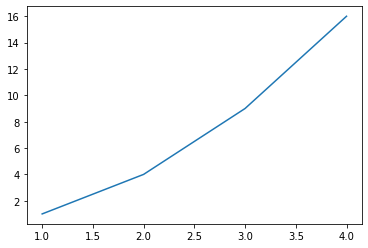

In [6]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
plt.show()

In [13]:
a = [0, 1, 2, 3]
a = [4, 5, 6, 7]
print(a)

[4, 5, 6, 7]
